In [1]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

matplotlib.rc("axes", unicode_minus = False)

In [4]:
df = pd.read_csv("SCALE불량.csv", encoding = "euc-kr")
df.head(3)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조


In [5]:
df['scale'].unique()

array(['양품', '불량'], dtype=object)

In [6]:
df['scale'] = df['scale'].replace({'양품': 0, '불량': 1})

In [7]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()

# # 'hsb' 열을 숫자로 인코딩
# df['hsb'] = label_encoder.fit_transform(df['hsb']) # 1: 적용, 0 : 미적용

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   int64 
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

In [9]:
df['datetime'] = pd.to_datetime(df['rolling_date'], format='%d%b%Y:%H:%M:%S', errors='coerce')
df['hour'] = df['datetime'].dt.hour
df.drop(columns=["rolling_date",'fur_ex_temp','plate_no','datetime', 'spec_long'],inplace=True)
# 'hour' 변수를 문자열(object)로 변환
df['hour'] = df['hour'].astype(str)

In [10]:
percentage_by_hour = df.groupby('hour')['scale'].mean() * 100
print(percentage_by_hour)

hour
0     34.090909
1     28.571429
10    42.500000
11    46.666667
12    51.219512
13    37.500000
14    25.581395
15    25.000000
16    34.146341
17    31.111111
18    27.500000
19    16.666667
2     37.209302
20    14.634146
21    13.953488
22    29.268293
23    39.534884
3     20.930233
4     26.190476
5     31.111111
6     30.303030
7     32.500000
8     25.000000
9     43.589744
Name: scale, dtype: float64


In [11]:
# 'hour' 변수를 문자열(object)로 변환
df['hour'] = df['hour'].astype(str)

In [12]:
numeric_df = df.select_dtypes(include=['float64', 'int64']) 
numeric_df.corr()  

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count
scale,1.000000,-0.098090,-0.189536,0.052115,0.222493,-0.035826,0.327817,-0.219581,-0.127695,0.375704,-0.040011
pt_thick,-0.098090,1.000000,-0.319894,-0.867125,-0.525317,0.206644,-0.665964,0.357260,0.338078,-0.363406,-0.845324
pt_width,-0.189536,-0.319894,1.000000,0.147979,0.200737,-0.100876,0.216879,-0.097273,-0.133329,-0.060320,0.350132
pt_length,0.052115,-0.867125,0.147979,1.000000,0.470846,-0.137895,0.603303,-0.333730,-0.276402,0.290828,0.818483
fur_heat_temp,0.222493,-0.525317,0.200737,0.470846,1.000000,-0.163792,0.787203,-0.373154,-0.313632,0.268803,0.488292
fur_heat_time,-0.035826,0.206644,-0.100876,-0.137895,-0.163792,1.000000,-0.349176,0.114804,0.736069,-0.083188,-0.166892
fur_soak_temp,0.327817,-0.665964,0.216879,0.603303,0.787203,-0.349176,1.000000,-0.596820,-0.560808,0.459210,0.627843
fur_soak_time,-0.219581,0.357260,-0.097273,-0.333730,-0.373154,0.114804,-0.596820,1.000000,0.632995,-0.308021,-0.399353
fur_total_time,-0.127695,0.338078,-0.133329,-0.276402,-0.313632,0.736069,-0.560808,0.632995,1.000000,-0.208733,-0.339263
rolling_temp,0.375704,-0.363406,-0.060320,0.290828,0.268803,-0.083188,0.459210,-0.308021,-0.208733,1.000000,0.250112


In [13]:
df.loc[df['rolling_temp'] >900, 'rolling_temp_>900'] = 1
df.loc[df['rolling_temp'] <=900, 'rolling_temp_>900'] = 0

df['pt_area'] = df['pt_length'] * df['pt_width']
df['fur_temp_gap'] = df['fur_heat_temp'] - df['fur_soak_temp']

df = df[df['rolling_temp'] != 0]

In [14]:
# from sklearn.preprocessing import MinMaxScaler

# # Min-Max Scaling을 적용할 수치형 변수들 선택
# numeric_columns = []
# for column in df.columns:
#     if pd.api.types.is_numeric_dtype(df[column]):
#         numeric_columns.append(column)

# # Min-Max Scaler 객체 생성
# scaler = MinMaxScaler()
# df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [15]:
df = pd.get_dummies(df, dtype=int)
df

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,0,32,3700,15100,1144,116,1133,59,259,934,...,0,0,0,0,0,0,0,1,0,0
1,0,32,3700,15100,1144,122,1135,53,238,937,...,0,0,0,0,0,0,0,1,0,0
2,0,33,3600,19200,1129,116,1121,55,258,889,...,0,0,0,0,0,0,0,1,0,0
3,0,33,3600,19200,1152,125,1127,68,266,885,...,0,0,0,0,0,0,0,1,0,0
4,0,38,3100,13300,1140,134,1128,48,246,873,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,19,3400,41500,1142,55,1151,86,203,948,...,0,0,0,0,0,1,0,0,0,0
996,0,19,3400,41500,1142,55,1151,86,209,948,...,0,0,0,0,0,1,0,0,0,0
997,0,17,3400,43700,1169,65,1163,77,227,948,...,0,0,0,0,0,1,0,0,0,0
998,0,17,3400,43700,1169,65,1163,77,204,948,...,0,0,0,0,0,0,1,0,0,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   scale                      994 non-null    int64  
 1   pt_thick                   994 non-null    int64  
 2   pt_width                   994 non-null    int64  
 3   pt_length                  994 non-null    int64  
 4   fur_heat_temp              994 non-null    int64  
 5   fur_heat_time              994 non-null    int64  
 6   fur_soak_temp              994 non-null    int64  
 7   fur_soak_time              994 non-null    int64  
 8   fur_total_time             994 non-null    int64  
 9   rolling_temp               994 non-null    int64  
 10  descaling_count            994 non-null    int64  
 11  rolling_temp_>900          994 non-null    float64
 12  pt_area                    994 non-null    int64  
 13  fur_temp_gap               994 non-null    int64  
 14 

In [17]:
# 데이터 구성:Series, DataFrame
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# export_graphviz: 나무 구조 생성 및 저장 
from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)
import graphviz

# 다른 방식(.dot -> .png 형식, 출력화면에 맞는)으로 Tree 출력
from subprocess import call
from IPython.display import Image

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
# Data 구조 확인
print("Data 구조:", df.shape)
print()
print("변수 : ", df.columns)

Data 구조: (994, 60)

변수 :  Index(['scale', 'pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp',
       'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 'fur_total_time',
       'rolling_temp', 'descaling_count', 'rolling_temp_>900', 'pt_area',
       'fur_temp_gap', 'spec_country_공통', 'spec_country_독일', 'spec_country_미국',
       'spec_country_영국', 'spec_country_일본', 'spec_country_프랑스',
       'spec_country_한국', 'steel_kind_C', 'steel_kind_T', 'hsb_미적용', 'hsb_적용',
       'fur_no_1호기', 'fur_no_2호기', 'fur_no_3호기', 'fur_input_row_1열',
       'fur_input_row_2열', 'rolling_method_CR(제어압연)',
       'rolling_method_TMCP(온도제어)', 'work_group_1조', 'work_group_2조',
       'work_group_3조', 'work_group_4조', 'hour_0', 'hour_1', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_2', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9'],
      dtype='

In [19]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df)
df_raw_dummy.head()

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,0,32,3700,15100,1144,116,1133,59,259,934,...,0,0,0,0,0,0,0,1,0,0
1,0,32,3700,15100,1144,122,1135,53,238,937,...,0,0,0,0,0,0,0,1,0,0
2,0,33,3600,19200,1129,116,1121,55,258,889,...,0,0,0,0,0,0,0,1,0,0
3,0,33,3600,19200,1152,125,1127,68,266,885,...,0,0,0,0,0,0,0,1,0,0
4,0,38,3100,13300,1140,134,1128,48,246,873,...,0,0,0,0,0,0,0,1,0,0


In [20]:
# 데이터 분리:설명변수, 목표변수 구분
df_raw_x = df_raw_dummy.drop("scale", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["scale"] 

# 데이터 분할 train_test_split(X: 설명변수, Y: 목표변수, test_size = test 데이터 비율)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (994, 59)
분할 후 설명변수 데이터 :Train (695, 59)   Test (299, 59)


In [21]:
# Data 구조 확인
print("Data 구조:", df_raw_dummy.columns)
print()
print("변수 : ", df_train_x.columns)

Data 구조: Index(['scale', 'pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp',
       'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 'fur_total_time',
       'rolling_temp', 'descaling_count', 'rolling_temp_>900', 'pt_area',
       'fur_temp_gap', 'spec_country_공통', 'spec_country_독일', 'spec_country_미국',
       'spec_country_영국', 'spec_country_일본', 'spec_country_프랑스',
       'spec_country_한국', 'steel_kind_C', 'steel_kind_T', 'hsb_미적용', 'hsb_적용',
       'fur_no_1호기', 'fur_no_2호기', 'fur_no_3호기', 'fur_input_row_1열',
       'fur_input_row_2열', 'rolling_method_CR(제어압연)',
       'rolling_method_TMCP(온도제어)', 'work_group_1조', 'work_group_2조',
       'work_group_3조', 'work_group_4조', 'hour_0', 'hour_1', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_2', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9'],
      dtype='object')

변수 :  I

In [22]:
# 목표변수 빈도 확인
print(df_raw_dummy.value_counts(["scale"]),"\n")
print("scale=1 비율  ", df_raw_dummy.value_counts(df_raw_dummy["scale"]==1)/len(df_raw_dummy))

scale
0        684
1        310
Name: count, dtype: int64 

scale=1 비율   scale
False    0.688129
True     0.311871
Name: count, dtype: float64


In [23]:
tree_uncust = DecisionTreeClassifier(random_state=1234 )
tree_uncust.fit(df_train_x, df_train_y)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncust.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncust.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.993


-> 이미 데이터가 너무완벽

In [24]:
# 실행옵션 확인
print(tree_uncust.get_params().keys())
print(tree_uncust.get_params().values())

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])
dict_values([0.0, None, 'gini', None, None, None, 0.0, 1, 2, 0.0, None, 1234, 'best'])


In [25]:
# 설명변수 중요도 계산
importance_dict = dict(zip(df_train_x.columns, tree_uncust.feature_importances_))

# 중요도를 데이터프레임으로 변환하여 저장
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])

# 중요도에 따라 내림차순으로 정렬
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# 결과 출력
print(df_importance)

# 테이블로 저장
df_importance.to_csv('feature_importance.csv', index=False)

                      Feature  Importance
8                rolling_temp    0.518365
22                    hsb_미적용    0.150227
5               fur_soak_temp    0.144691
0                    pt_thick    0.108436
9             descaling_count    0.066704
2                   pt_length    0.008305
7              fur_total_time    0.003273
36                     hour_1    0.000000
37                    hour_10    0.000000
35                     hour_0    0.000000
45                    hour_18    0.000000
38                    hour_11    0.000000
39                    hour_12    0.000000
40                    hour_13    0.000000
41                    hour_14    0.000000
42                    hour_15    0.000000
43                    hour_16    0.000000
44                    hour_17    0.000000
48                    hour_20    0.000000
46                    hour_19    0.000000
47                     hour_2    0.000000
33              work_group_3조    0.000000
49                    hour_21    0

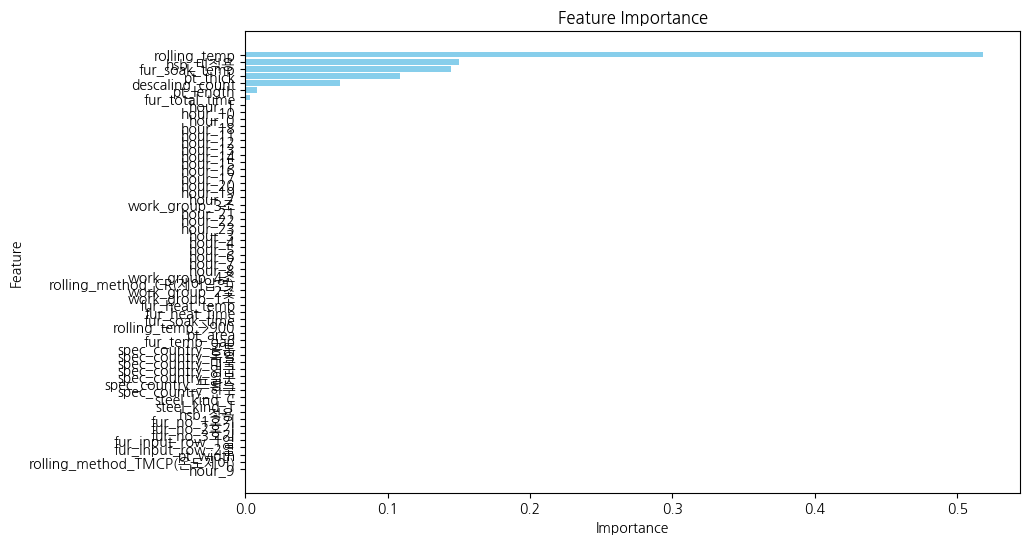

In [26]:
# 중요도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(df_importance['Feature'], df_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 변수가 위에 오도록 순서 뒤집기
plt.show()

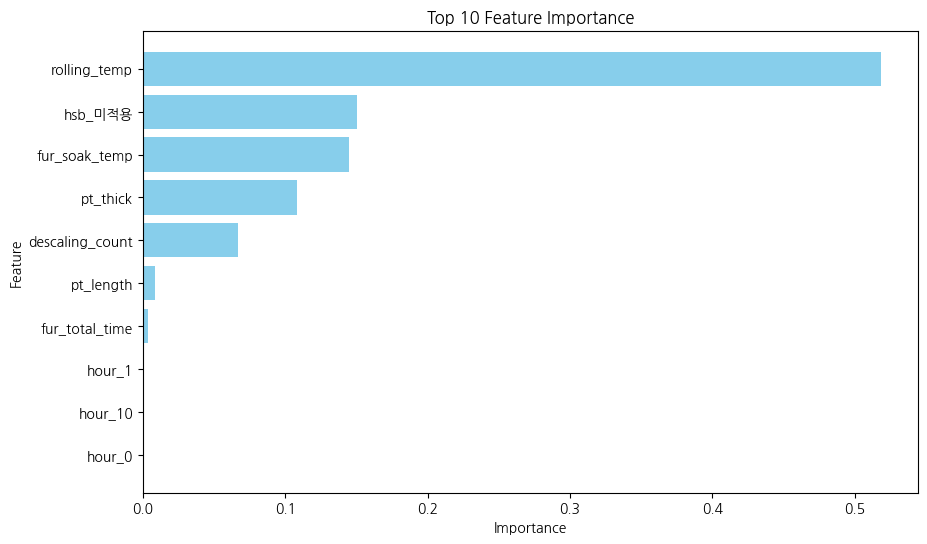

In [27]:
import matplotlib.pyplot as plt

# 상위 10개 주요 변수 데이터만 추출
top_10_importance = df_importance.head(10)

# 중요도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(top_10_importance['Feature'], top_10_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 변수가 위에 오도록 순서 뒤집기
plt.show()


In [28]:
from subprocess import call
from IPython.display import Image

import graphviz

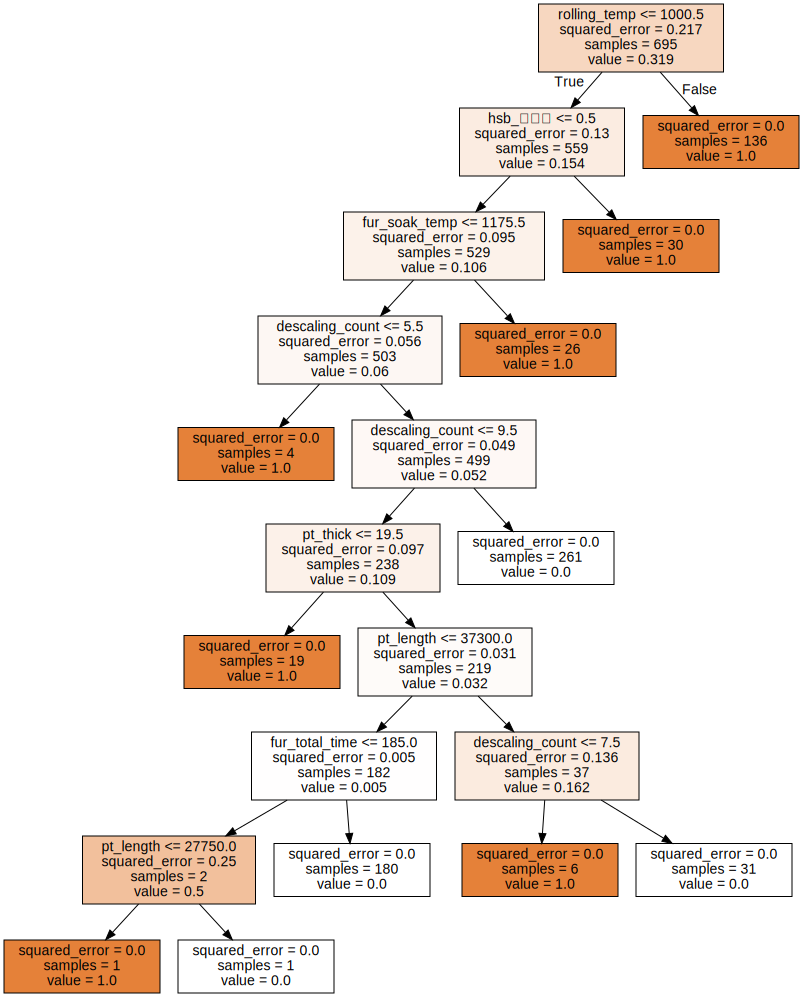

In [29]:
v_feature_name = df_train_x.columns

tree_low = DecisionTreeRegressor(random_state=1234)
tree_low.fit(df_train_x, df_train_y)

export_graphviz(tree_low, out_file="tree_low.dot", class_names = ["Active", "Churn"], 
                feature_names = v_feature_name, impurity = True, filled = True)

with open("tree_low.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [30]:
call(['dot', '-Tpng', 'tree_low.dot', '-o', 'tree_low.png', '-Gdpi=600'])
Image(filename = 'tree_low.png')